# Driver Behavior Dataset

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def get_event(seconds_passed, groundTruth):
    for _, row in groundTruth.iterrows():
        if row[' inicio'] <= seconds_passed <= row[' fim']:
            return row['evento']
    return None

In [20]:
def getGroundTruth(df, groundTruth_orig):
    df['seconds_passed'] = (df['uptimeNanos'] - df['uptimeNanos'].iloc[0]) / 1e9 # Converting timestamp to seconds passed
    df['evento'] = df['seconds_passed'].apply(lambda x: get_event(x, groundTruth_orig)) # Getting the event for each row based on seconds passed
    return df


In [21]:
def getData(driver):
    accLinear_orig = pd.read_csv(f'data/{driver}/aceleracaoLinear_terra.csv')
    acelerometro_orig = pd.read_csv(f'data/{driver}/acelerometro_terra.csv')
    giroscopio_orig = pd.read_csv(f'data/{driver}/giroscopio_terra.csv')
    groundTruth_orig = pd.read_csv(f'data/{driver}/groundTruth.csv')

    # Renaming columns to avoid conflicts
    accLinear = accLinear_orig.rename(columns={'x': 'x_accLinear', 'y': 'y_accLinear', 'z': 'z_accLinear'}, inplace=False) 
    acelerometro = acelerometro_orig.rename(columns={'x': 'x_acelerometro', 'y': 'y_acelerometro', 'z': 'z_acelerometro'}, inplace=False) 
    giroscopio = giroscopio_orig.rename(columns={'x': 'x_giroscopio', 'y': 'y_giroscopio', 'z': 'z_giroscopio'}, inplace=False)

    # Merging all dataframes
    df = pd.concat([accLinear, acelerometro, giroscopio], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]

    # Converting timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M:%S')
    # Getting the event for each row based on seconds passed
    df = getGroundTruth(df, groundTruth_orig)

    # Changing Nones to 'sem_evento'
    df['evento'] = df['evento'].fillna('sem_evento')

    return df

In [22]:
df_16 = getData(16)
df_17 = getData(17)
df_20 = getData(20)
df_21 = getData(21)

Plotting different sensors to see the difference

In [23]:
def plot_sensor_data(data, sensor=None, figsize=(10, 4), begin=None, end=None):
    if begin is not None:
        data = data[data['seconds_passed'] >= begin]
        if end < begin:
            raise ValueError('End must be greater than begin')

    if end is not None:
        data = data[data['seconds_passed'] <= end]

    if sensor is None:
        sensor = ['acelerometro', 'accLinear', 'giroscopio']
    
    plt.figure(figsize=figsize)
    plt.plot(data['seconds_passed'], data[f'x_{sensor}'], label=f'x_{sensor}')
    plt.plot(data['seconds_passed'], data[f'y_{sensor}'], label=f'y_{sensor}')
    plt.plot(data['seconds_passed'], data[f'z_{sensor}'], label=f'z_{sensor}')
    
    # Highlight regions where 'evento' is not 'sem_evento'
    highlight_color = 'lightgrey'  # Use the same color for all events

    for i in range(len(data) - 1):
        if data['evento'].iloc[i] != 'sem_evento':
            plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1], 
                        alpha=0.3, color=highlight_color, edgecolor='none')
            if i == 0 or data['evento'].iloc[i] != data['evento'].iloc[i - 1]:
                plt.text((data['seconds_passed'].iloc[i] + data['seconds_passed'].iloc[i + 1]) / 2, 
                         max(data[f'x_{sensor}'].max(), data[f'y_{sensor}'].max(), data[f'z_{sensor}'].max()), 
                         data['evento'].iloc[i], 
                         horizontalalignment='left', 
                         verticalalignment='top', 
                         fontsize=12, 
                         color='black', 
                         rotation=0)

    plt.xlabel('Uptime (seconds)')
    plt.ylabel(sensor.capitalize())
    plt.legend()
    plt.xticks(range(int(data['seconds_passed'].min()), int(data['seconds_passed'].max()) + 1))
    plt.show()


/tmp/ipykernel_26896/1071966741.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1],


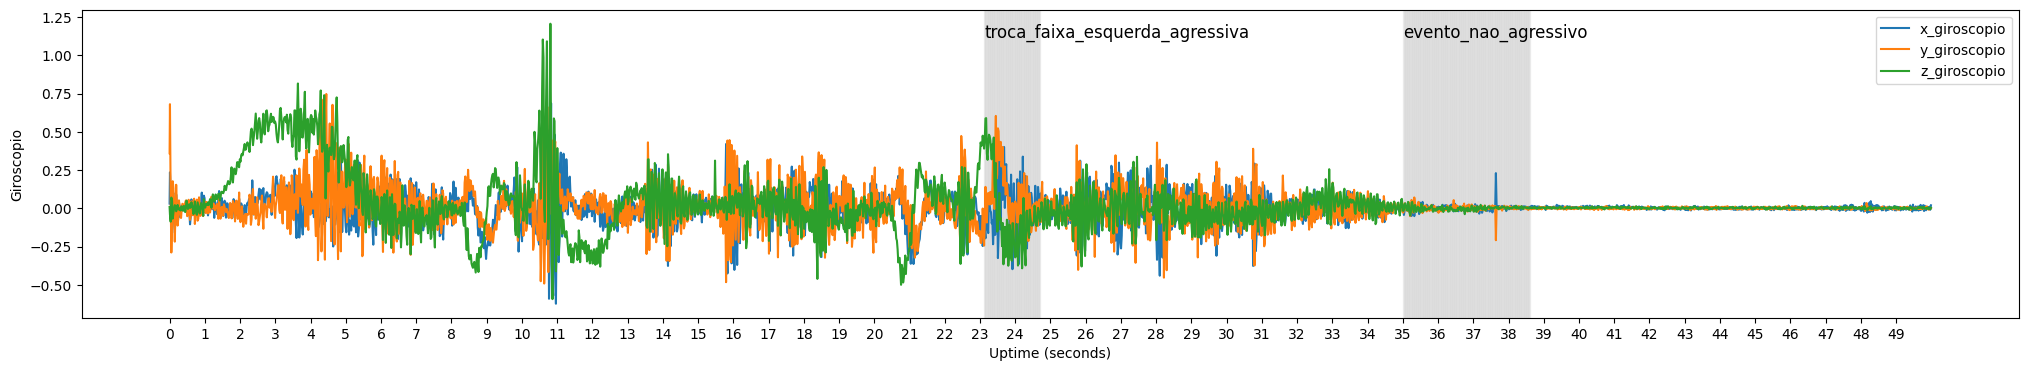

In [24]:
plot_sensor_data(df_21, 'giroscopio', figsize=(25, 4), begin=0, end=50)

In [62]:
data = [df_16, df_17, df_20, df_21]
cols = ['timestamp', 'uptimeNanos']
for i in range(len(data)):
    data[i] = data[i].drop(cols, axis=1, inplace=False)

# Machine Learning Algorithm

First, let's try directly applying a RF algorithm using a single drive to see what happens

In [48]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Using sliding windows to allow for classification

In [86]:
def get_features(window):
    # Features such as mean, max, min and std from the window
    features = np.array([])
    features = np.append(features, [window.mean(), window.max(), window.min(), window.std(), window.range()])
    return features

In [95]:
def create_sliding_windows(data, window_size=7, step_size=1):
    X = []
    y = []
    # splits = np.zeros(len(data))
    cont = 0
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])

            if data[k]['evento'][i] == 'sem_evento':
                continue
            if data[k]['evento'][end - 1] == 'sem_evento':
                continue
            
            window_label = data[k]['evento'][i] # Getting the most frequent event in the window
            window = data[k][i:end].drop(['evento', 'seconds_passed'], axis=1, inplace=False) # Dropping 'evento' and 'seconds_passed' columns
            features = get_features(window) # Getting features from the window

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order

            window = np.append(window.to_numpy().flatten(), features) # Flattening the window and appending the features
            X.append(window)
            y.append(window_label)

        # splits[k] = cont

    return np.array(X), np.array(y)

In [96]:
window_size = 7
step_size = 1
X, y = create_sliding_windows(data, window_size, step_size) # This will create the sliding windows with a 3D X and 1D y
X.shape, y.shape

((10663, 99), (10663,))

Splitting without losing the time property

In [97]:
def split_by_series(X, y, splits_end, proportion):

    splits_begin = [int(splits_end[0] * proportion)] + [int((splits_end[i] - splits_end[i - 1]) * proportion) + splits_end[i - 1] for i in range(1, len(splits_end))] # This will split the data into train and test sets

    splits_begin = [int(x) for x in splits_begin]
    splits_end = [int(x) for x in splits_end]

    X_train = X[:splits_begin[0]]
    X_test = X[splits_begin[0]:splits_end[0]]
    y_train = y[:splits_begin[0]]
    y_test = y[splits_begin[0]:splits_end[0]]

    for i in range(1, len(data)):
        X_train = np.append(X_train, X[splits_end[i - 1]:splits_begin[i]], axis=0)
        X_test = np.append(X_test, X[splits_begin[i]:splits_end[i]], axis=0)
        y_train = np.append(y_train, y[splits_end[i - 1]:splits_begin[i]], axis=0)
        y_test = np.append(y_test, y[splits_begin[i]:splits_end[i]], axis=0)

    return X_train, X_test, y_train, y_test

In [98]:
def get_unique_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Since we already have windows with labels, we can split the data into train and test sets

Veryfing the balance of the split

In [100]:
print('Train set:', get_unique_counts(y_train))
print('Test set:', get_unique_counts(y_test))
print('In test set, but not in train set:', set(y_test) - set(y_train))
print('In train set, but not in test set:', set(y_train) - set(y_test))

Train set: {'aceleracao_agressiva': 1716, 'curva_direita_agressiva': 1495, 'curva_esquerda_agressiva': 1515, 'evento_nao_agressivo': 1964, 'freada_agressiva': 1081, 'troca_faixa_direita_agressiva': 440, 'troca_faixa_esquerda_agressiva': 319}
Test set: {'aceleracao_agressiva': 414, 'curva_direita_agressiva': 387, 'curva_esquerda_agressiva': 365, 'evento_nao_agressivo': 480, 'freada_agressiva': 309, 'troca_faixa_direita_agressiva': 94, 'troca_faixa_esquerda_agressiva': 84}
In test set, but not in train set: set()
In train set, but not in test set: set()


Creating and training the classifier

In [101]:
def fit_RF(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, classification_report(y_test, y_pred)

In [102]:
clf, report = fit_RF(X_train, y_train, X_test, y_test)

y_pred = clf.predict(X_test)
print(f"Classification report:\n{classification_report(y_test, y_pred)}")

Classification report:
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.93      0.99      0.96       414
       curva_direita_agressiva       0.96      1.00      0.98       387
      curva_esquerda_agressiva       0.98      0.99      0.98       365
          evento_nao_agressivo       0.92      0.93      0.93       480
              freada_agressiva       0.99      0.94      0.96       309
 troca_faixa_direita_agressiva       1.00      0.84      0.91        94
troca_faixa_esquerda_agressiva       0.97      0.76      0.85        84

                      accuracy                           0.95      2133
                     macro avg       0.96      0.92      0.94      2133
                  weighted avg       0.96      0.95      0.95      2133



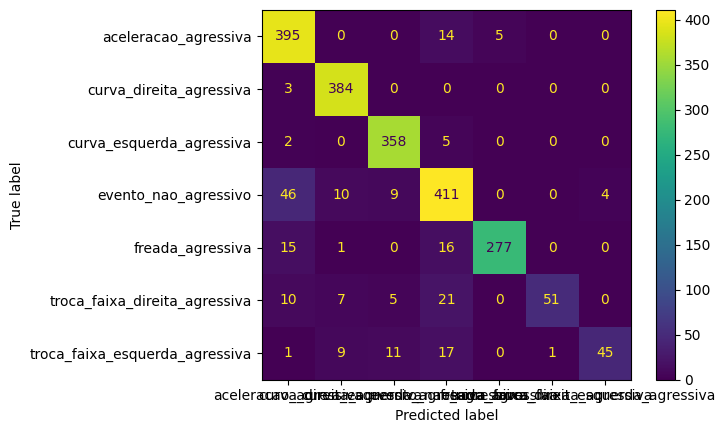

In [59]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()